In [1]:
%%capture
!pip install transformers trl accelerate torch bitsandbytes peft datasets -qU

In [2]:
%%capture
!pip install flash_attn

In [3]:
# from google.colab import drive
# drive.mount(‘/content/gdrive’)

In [3]:
import pandas as pd

In [ ]:
import os
import torch
from datasets import Dataset
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Model from Hugging Face hub
# base_model = "meta-llama/Llama-2-7b-chat-hf"
base_model = "mistralai/Mistral-7B-Instruct-v0.2"
# base_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"
#base_model = "meta-llama/Meta-Llama-3-8B-Instruct"

# Fine-tuned model
new_model = "/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/mistral/" + base_model.split("/")[-1]

In [8]:
#dataset
df = pd.read_csv("content/train_data.csv")

In [9]:
def create_prompt(statement1, statement2, relationship):

  system_message = """<s>[INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.[/INST]""".format(statement1, statement2)
  response = f"{relationship}</s>"

  # system_message = """You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.""".format(statement1, statement2)
  # response = f"\n{relationship}"

  full_prompt = ""
  full_prompt += system_message
  full_prompt += response

  return full_prompt

df['instruction_prompt'] = df.apply(lambda row: create_prompt(row['text1'], row['text2'], row["divergent_or_not_divergent"]), axis=1)

In [10]:
df.head()

,text1,text2,divergent_or_not_divergent,instruction_prompt
0,Formulation of genetically modified food endan...,Genetically modified food is often subject to ...,divergent,<s>[INST]You are given a task to find if the g...
1,Formulation of genetically modified food endan...,Many of the processes employed in genetic modi...,divergent,<s>[INST]You are given a task to find if the g...
2,Tilling is not a hard requirement for farming ...,"Conventional tilling, needed to keep non-GM cr...",divergent,<s>[INST]You are given a task to find if the g...
3,Use of the herbicide glyphosate has dramatical...,Multiple studies linking glyphosate to numerou...,divergent,<s>[INST]You are given a task to find if the g...
4,The recent rise in celiac disease correlates w...,While the study referenced above touches on po...,divergent,<s>[INST]You are given a task to find if the g...


In [11]:
print(new_model)

/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/mistral/Mistral-7B-Instruct-v0.2


In [12]:
tds = Dataset.from_pandas(df[['instruction_prompt']])
tds

Dataset({
    features: ['instruction_prompt'],
    num_rows: 257
})

In [13]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

In [14]:
!pip install huggingface_hub

from huggingface_hub import notebook_login

notebook_login()

In [16]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map='auto',
    attn_implementation="flash_attention_2"
)
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [17]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [18]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    task_type="CAUSAL_LM"
)

In [19]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [20]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    print(torch.cuda.device_count())
    model.is_parallelizable = True
    model.model_parallel = True

In [58]:
args = TrainingArguments(
  output_dir = "/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/mistral",
  num_train_epochs=10,
  #max_steps = 1000, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 12,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  evaluation_strategy="no",
  #evaluation_strategy="steps",
  # eval_steps=10, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2.5e-5,
  bf16=True,
  # lr_scheduler_type='constant',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
trainer = SFTTrainer(
    model=model,
    train_dataset=tds,
    peft_config=peft_config,
    dataset_text_field="instruction_prompt",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=args,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/257 [00:00<?, ? examples/s]

In [23]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss
10,2.202000
20,1.326000
30,0.663500
40,0.471900
50,0.431700
60,0.426900
70,0.419400
80,0.389800
90,0.400100
100,0.396500


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers foun

TrainOutput(global_step=220, training_loss=0.5213185147805648, metrics={'train_runtime': 663.923, 'train_samples_per_second': 3.871, 'train_steps_per_second': 0.331, 'total_flos': 4.90768197666816e+16, 'train_loss': 0.5213185147805648, 'epoch': 10.0})

In [24]:
trainer.save_model(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [25]:
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [26]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=150,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0]

In [27]:
test_df = pd.read_csv("content/test_data.csv")

In [28]:
zero_shot = []
for i in range(len(zero_shot), len(test_df)):
  prompt = """[INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Let's work this out with the statements provided below in a step by step way to be sure we have the right answer. The first statement is the value for the key 'Statement 1:' and the second statement is the value for the key 'Statement 2:' in the dictionary.\nStatement 1: {}\nStatement 2: {}\nYour final answer should only contain the word 'Divergent' or 'Not Divergent'.[/INST]""".format(test_df.iloc[i]['text1'], test_df.iloc[i]['text2'])
  zero_shot.append(generate_response(prompt, merged_model))
  if i % 10 == 0:
    print(i+1)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241


In [30]:
test_df.head()

,text1,text2,divergent or not divergent
0,The state should abide by the precautionary pr...,Genetically modified crops can only be grown i...,divergent
1,While many agricultural practices may be seen ...,Many of the processes employed in genetic modi...,divergent
2,Genetically modified crops can be harmful to t...,"Intensive agriculture as a whole, not specific...",divergent
3,Genetically modified crops can be harmful to t...,Genetic modification can be used to prevent ce...,divergent
4,Genetically modified crops can be harmful to t...,GM crops are often modified in ways that can m...,divergent


In [32]:
test_df['mistral_output'] = zero_shot

In [33]:
test_df.head()

,text1,text2,divergent or not divergent,mistral_output
0,The state should abide by the precautionary pr...,Genetically modified crops can only be grown i...,divergent,<s> [INST]You are given a task to find if the ...
1,While many agricultural practices may be seen ...,Many of the processes employed in genetic modi...,divergent,<s> [INST]You are given a task to find if the ...
2,Genetically modified crops can be harmful to t...,"Intensive agriculture as a whole, not specific...",divergent,<s> [INST]You are given a task to find if the ...
3,Genetically modified crops can be harmful to t...,Genetic modification can be used to prevent ce...,divergent,<s> [INST]You are given a task to find if the ...
4,Genetically modified crops can be harmful to t...,GM crops are often modified in ways that can m...,divergent,<s> [INST]You are given a task to find if the ...


In [29]:
zero_shot[200]

"<s> [INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. L

In [52]:
index = zero_shot[0].find("[/INST]")
print(zero_shot[5])

<s> [INST]You are given a task to find if the given pair of statements are divergent or not. For example, the statement 'Community water fluoridation has been a proven method to improve health for over 70 years.' and 'Excess amounts of fluoride ions in drinking water has negative health effects.' are a pair of divergent statements because the former establishes water fluoridation as a safe method to improve public health whereas the latter discourages the use of flourination as excess flouride ions have detrimental health effects. Here is another example: the statements 'Compared to the flu, the death rate for Covid-19 patients was very high.' and 'Higher mortality of Covid-19 could be due to medical constraints created by the sudden influx of patients over a short period of time.' are not a divergent pair of statements because the former compares the mortality of Covid-19 to the flu whereas the latter discusses the possible reasons for the high mortality rate due to Covid-19 virus. Le

In [53]:
print(index)
print(zero_shot[5][index:])

1753
or 'Not Divergent'.[/INST] Based on the given statements, they are divergent. The first statement expresses a concern about the potential negative impact of out-crossing in genetically modified crops on biodiversity. The second statement, on the other hand, describes out-crossing as a naturally occurring and beneficial phenomenon in plants that promotes genotypic diversity and continued successful survival. These two perspectives are in conflict with each other.</s>


In [48]:
zero_stance = [""] * len(zero_shot)
for i in range(len(zero_shot)):
  index = zero_shot[i].find("[/INST]")
  temp = zero_shot[i][index:]
  if " Not Divergent" in temp:
    zero_stance[i] = "Not Divergent"
  elif " Divergent" in temp:
    zero_stance[i] = "Divergent"

In [49]:
print(zero_stance)

['Not Divergent', 'Not Divergent', 'Not Divergent', 'Divergent', '', '', '', 'Divergent', '', '', 'Divergent', '', 'Not Divergent', '', 'Not Divergent', 'Divergent', 'Divergent', 'Not Divergent', 'Divergent', '', 'Not Divergent', 'Not Divergent', 'Divergent', 'Not Divergent', 'Not Divergent', 'Divergent', 'Divergent', '', 'Divergent', 'Divergent', 'Not Divergent', 'Divergent', '', 'Not Divergent', '', 'Not Divergent', 'Not Divergent', 'Not Divergent', 'Divergent', 'Divergent', 'Divergent', 'Not Divergent', 'Not Divergent', 'Divergent', 'Not Divergent', 'Not Divergent', 'Not Divergent', '', 'Divergent', '', 'Not Divergent', 'Not Divergent', '', 'Not Divergent', 'Not Divergent', 'Divergent', '', '', 'Not Divergent', 'Not Divergent', '', 'Divergent', 'Not Divergent', 'Not Divergent', 'Not Divergent', 'Divergent', 'Not Divergent', 'Not Divergent', 'Not Divergent', '', 'Not Divergent', 'Not Divergent', '', 'Not Divergent', 'Divergent', 'Divergent', 'Not Divergent', '', 'Not Divergent', 'Not

In [54]:
test_df['final_val'] = zero_stance
# test_df['mistral-8x7B-stance-b12 FewShot'] = zero_stance

In [59]:
csv_data = test_df.to_csv("/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/test_data with mistral cot response.csv", index = False)
csv_data = test_df.to_csv("/content/drive/MyDrive/Dartmouth /2024 Spring/Computational Healthcare Project/test_data with mistral cot response backup.csv", index = False)

In [4]:
test_values_df = pd.read_csv("./test_data with mistral cot response.csv")

In [5]:
from sklearn.metrics import classification_report
print(classification_report(list(test_values_df['Divergent or Not Divergent']), list(test_values_df['final_val'])))

               precision    recall  f1-score   support

    Divergent       0.68      0.42      0.52       138
Not Divergent       0.49      0.74      0.59       104

     accuracy                           0.56       242
    macro avg       0.59      0.58      0.56       242
 weighted avg       0.60      0.56      0.55       242



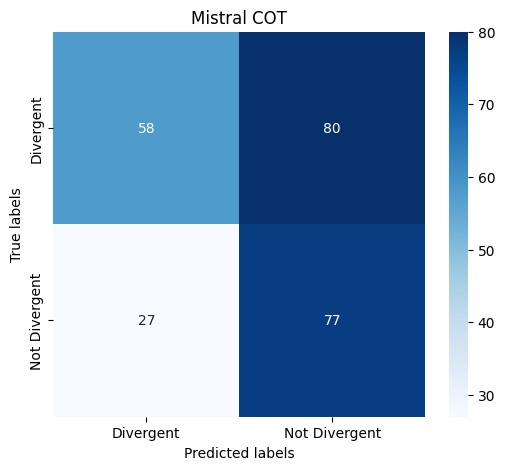

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test = test_values_df['Divergent or Not Divergent']
y_pred = test_values_df['final_val']
cm = confusion_matrix(y_test, y_pred, labels=['Divergent', 'Not Divergent'])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
                 xticklabels=['Divergent', 'Not Divergent'], yticklabels=['Divergent', 'Not Divergent'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.title('Mistral COT')
plt.show()